In [1]:
%matplotlib inline

Receptor-ligand analysis
========================

This example shows how to run the receptor-ligand analysis.

It uses an efficient re-implementation of the `cellphonedb` algorithm
which can handle large number of interacting pairs (100k+) and cluster
combinations (100+).

:::{seealso}

See {doc}`compute_nhood_enrichment` for
finding cluster neighborhood with {func}`squidpy.gr.nhood_enrichment`.

:::


In [3]:
import squidpy as sq

adata = sq.datasets.seqfish()
adata

AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined'
    uns: 'celltype_mapped_refined_colors'
    obsm: 'X_umap', 'spatial'

To get started, we just need an `anndata.AnnData` object with some
clustering information. Below are some useful parameters of
`squidpy.gr.ligrec`:

> -   `n_perms` - number of permutations for the permutation test.
> -   `interactions` - list of interaction, by default we fetch all
>     available interactions from `omnipath`.
> -   `{interactions,transmitter,receiver}_params` - parameters used if
>     downloading the `interactions`, see
>     `omnipah.interactions.import_intercell_network` for more
>     information.
> -   `threshold` - percentage of cells required to be expressed in a
>     given cluster.
> -   `corr_method` - false discovery rate (FDR) correction method to
>     use.

Since we\'re interested in receptors and ligands in this example, we
specify these categories in `receiver_params` and `transmitter_params`,
respectively. If desired, we can also restrict the resources to just a
select few. For example, in order to only use `cellphonedb`, set
`interactions_params={'resources': 'CellPhoneDB'}`.


In [4]:
res = sq.gr.ligrec(
    adata,
    n_perms=1000,
    cluster_key="celltype_mapped_refined",
    copy=True,
    use_raw=False,
    transmitter_params={"categories": "ligand"},
    receiver_params={"categories": "receptor"},
)

  0%|          | 0/1000 [00:00<?, ?permutation/s]

First, we inspect the calculated means. The resulting object is a
`pandas.DataFrame`, with rows corresponding to interacting pairs and
columns to cluster combinations.


In [5]:
res["means"].head()

cluster_1     Allantois                                          \
cluster_2     Allantois Anterior somitic tissues Cardiomyocytes   
source target                                                     
KDR    PECAM1  0.142857                 0.294237       0.150901   
IGF1   KDR     0.162338                 0.484172       0.250242   
PDGFA  KDR     0.240260                 0.562094       0.328164   
NRP1   KDR     0.532468                 0.854302       0.620372   
FGF3   FGFR3   0.324675                 0.162744       0.288913   

cluster_1                                                                    \
cluster_2     Cranial mesoderm Definitive endoderm Dermomyotome Endothelium   
source target                                                                 
KDR    PECAM1         0.233090            0.183007     0.187666    1.475811   
IGF1   KDR            0.232278            0.164777     0.246182    2.253158   
PDGFA  KDR            0.310200            0.242699     0.324104    2.331080   
NRP1   KDR            0.602408            0.534906     0.616312    2.623288   
FGF3   FGFR3          0.216180            0.467593     0.204117    0.191248   

cluster_1                                                       ...  \
cluster_2     Erythroid Forebrain/Midbrain/Hindbrain  Gut tube  ...   
source target                                                   ...   
KDR    PECAM1  0.214416                     0.160415  0.190973  ...   
IGF1   KDR     0.192922                     0.141502  0.169111  ...   
PDGFA  KDR     0.270844                     0.219424  0.247033  ...   
NRP1   KDR     0.563052                     0.511632  0.539240  ...   
FGF3   FGFR3   0.139589                     0.705757  0.270203  ...   

cluster_1           Surface ectoderm                                         \
cluster_2     Lateral plate mesoderm Low quality Mixed mesenchymal mesoderm   
source target                                                                 
KDR    PECAM1               0.271419    0.302056                   0.277021   
IGF1   KDR                  0.327692    0.292735                   0.289093   
PDGFA  KDR                  1.748416    1.713459                   1.709817   
NRP1   KDR                  0.558029    0.523072                   0.519430   
FGF3   FGFR3                0.255896    0.234674                   0.632132   

cluster_1                                                            \
cluster_2           NMP Neural crest Presomitic mesoderm Sclerotome   
source target                                                         
KDR    PECAM1  0.254229     0.318590            0.274281   0.287045   
IGF1   KDR     0.230291     0.306367            0.368467   0.286925   
PDGFA  KDR     1.651015     1.727091            1.789191   1.707649   
NRP1   KDR     0.460628     0.536704            0.598804   0.517262   
FGF3   FGFR3   0.557881     0.299989            0.268179   0.268655   

cluster_1                                                       
cluster_2     Spinal cord Splanchnic mesoderm Surface ectoderm  
source target                                                   
KDR    PECAM1    0.242653            0.235369         0.276529  
IGF1   KDR       0.251546            0.270060         0.323970  
PDGFA  KDR       1.672270            1.690784         1.744694  
NRP1   KDR       0.481883            0.500397         0.554307  
FGF3   FGFR3     0.478236            0.385616         0.393883  

[5 rows x 484 columns]

Next, we take a look at the p-values. If `corr_method != None`, this
will contained the corrected p-values. The p-values marked as
[NaN]{.title-ref} correspond to interactions, which did not pass the
filtering `threshold` specified above.


In [6]:
res["pvalues"].head()

cluster_1     Allantois                                          \
cluster_2     Allantois Anterior somitic tissues Cardiomyocytes   
source target                                                     
KDR    PECAM1     1.000                    0.941          1.000   
IGF1   KDR        1.000                    0.131          0.999   
PDGFA  KDR        1.000                    0.321          0.999   
NRP1   KDR        0.909                    0.074          0.823   
FGF3   FGFR3      0.767                    1.000          1.000   

cluster_1                                                                    \
cluster_2     Cranial mesoderm Definitive endoderm Dermomyotome Endothelium   
source target                                                                 
KDR    PECAM1            0.999               1.000         1.00         0.0   
IGF1   KDR               1.000               1.000         1.00         0.0   
PDGFA  KDR               0.999               1.000         1.00         0.0   
NRP1   KDR               0.885               0.967         0.83         0.0   
FGF3   FGFR3             1.000               0.076         1.00         1.0   

cluster_1                                                      ...  \
cluster_2     Erythroid Forebrain/Midbrain/Hindbrain Gut tube  ...   
source target                                                  ...   
KDR    PECAM1     1.000                        1.000    1.000  ...   
IGF1   KDR        1.000                        1.000    1.000  ...   
PDGFA  KDR        1.000                        1.000    1.000  ...   
NRP1   KDR        0.939                        0.993    0.975  ...   
FGF3   FGFR3      1.000                        0.000    1.000  ...   

cluster_1           Surface ectoderm                                         \
cluster_2     Lateral plate mesoderm Low quality Mixed mesenchymal mesoderm   
source target                                                                 
KDR    PECAM1                  1.000         1.0                        1.0   
IGF1   KDR                     0.996         1.0                        1.0   
PDGFA  KDR                     0.000         0.0                        0.0   
NRP1   KDR                     1.000         1.0                        1.0   
FGF3   FGFR3                   1.000         1.0                        0.0   

cluster_1                                                                     \
cluster_2        NMP Neural crest Presomitic mesoderm Sclerotome Spinal cord   
source target                                                                  
KDR    PECAM1  1.000          1.0               1.000      0.999         1.0   
IGF1   KDR     0.996          1.0               0.745      0.910         1.0   
PDGFA  KDR     0.000          0.0               0.000      0.000         0.0   
NRP1   KDR     1.000          1.0               0.992      0.991         1.0   
FGF3   FGFR3   0.004          1.0               1.000      0.975         0.0   

cluster_1                                           
cluster_2     Splanchnic mesoderm Surface ectoderm  
source target                                       
KDR    PECAM1               1.000            1.000  
IGF1   KDR                  1.000            0.990  
PDGFA  KDR                  0.000            0.000  
NRP1   KDR                  1.000            1.000  
FGF3   FGFR3                0.608            0.389  

[5 rows x 484 columns]

Any interaction metadata downloaded from `omnipath`, such as the
interaction type, can be accessed as:


In [7]:
res["metadata"].head()

,,aspect_intercell_source,aspect_intercell_target,category_intercell_source,category_intercell_target,category_source_intercell_source,category_source_intercell_target,consensus_direction,consensus_inhibition,consensus_score_intercell_source,consensus_score_intercell_target,...,scope_intercell_source,scope_intercell_target,secreted_intercell_source,secreted_intercell_target,sources,transmitter_intercell_source,transmitter_intercell_target,type,uniprot_intercell_source,uniprot_intercell_target
source,target,,,,,,,,,,,,,,,,,,,,,
KDR,PECAM1,functional,functional,ligand,receptor,resource_specific,resource_specific,True,False,1,10,...,generic,generic,True,False,Wang,True,False,post_translational,P35968,P16284
IGF1,KDR,functional,functional,ligand,receptor,resource_specific,resource_specific,True,False,19,23,...,generic,generic,True,True,Wang,True,False,post_translational,P05019,P35968
PDGFA,KDR,functional,functional,ligand,receptor,resource_specific,resource_specific,True,False,18,23,...,generic,generic,True,True,Wang,True,False,post_translational,P04085,P35968
NRP1,KDR,functional,functional,ligand,receptor,resource_specific,resource_specific,True,False,2,23,...,generic,generic,True,True,BioGRID;CellChatDB-cofactors;HPRD;Wang,True,False,post_translational,O14786,P35968
FGF3,FGFR3,functional,functional,ligand,receptor,resource_specific,resource_specific,False,False,17,19,...,generic,generic,True,True,Baccin2019;CellCall;CellPhoneDB;CellTalkDB;Cel...,True,False,post_translational,P11487,P22607


In order to plot the results, we can run `squidpy.pl.ligrec`. Some
useful parameters are:

> -   `{source,target}_groups` - only plot specific source/target
>     clusters.
> -   `dendrogram` - whether to hierarchically cluster the rows, columns
>     or both.
> -   `mean_range` - plot only interactions whose means are in this
>     range.
> -   `pval_threshold` - plot only interactions whose p-values are below
>     this threshold.

In the plot below, to highlight significance, we\'ve marked all p-values
\<= 0.005 with tori.


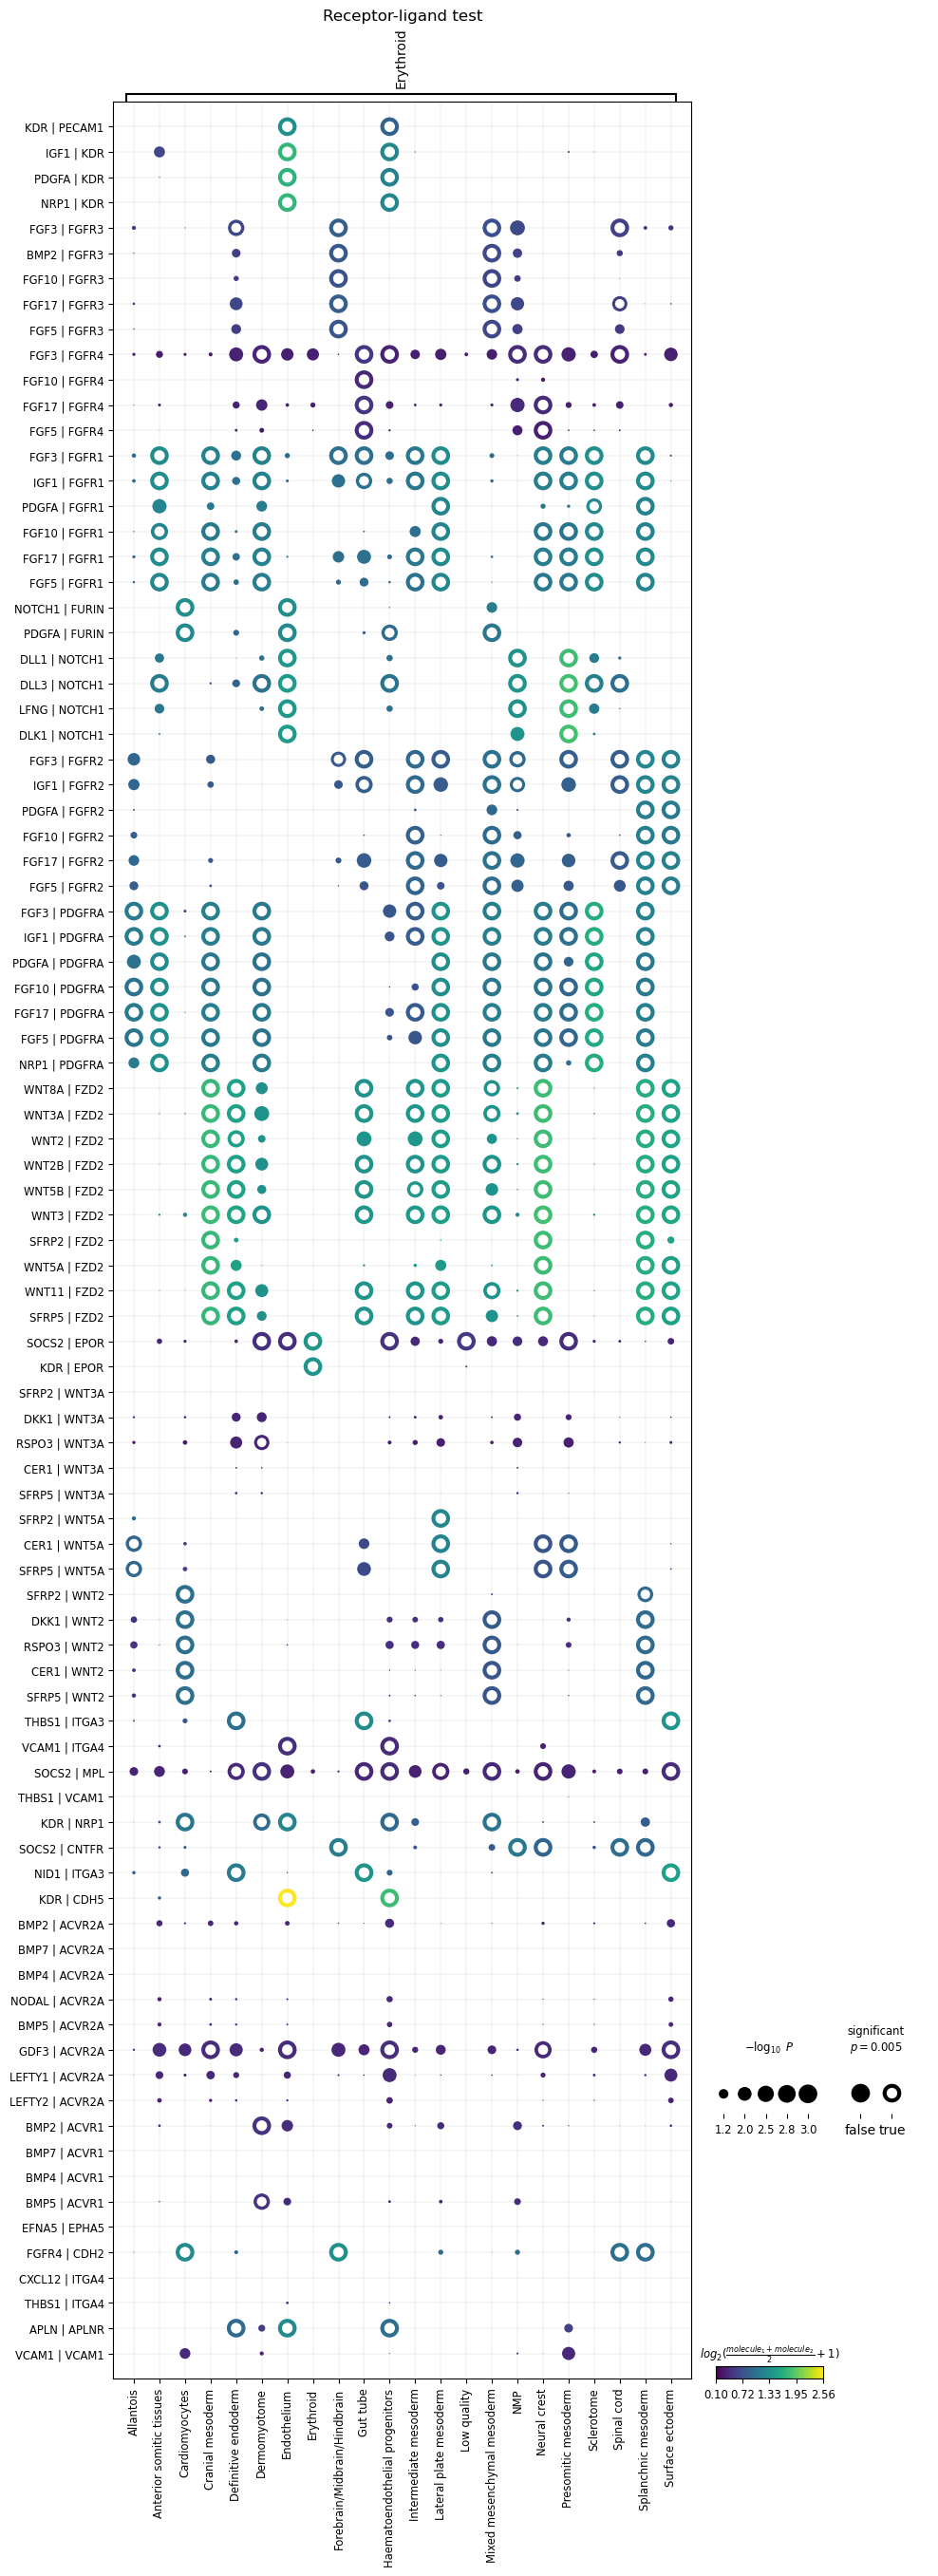

In [8]:
sq.pl.ligrec(res, source_groups="Erythroid", alpha=0.005)